Fetching linescore for game ID 718760
Original Line: White Sox 0 1 0 2 0 0 0 0 1  4   10  1  
Parts: ['White', 'Sox', '0', '1', '0', '2', '0', '0', '0', '0', '1', '4', '10', '1']
Team Name: White Sox
Original Line: Astros    2 0 0 1 0 0 1 2 0  6   11  0
Parts: ['Astros', '2', '0', '0', '1', '0', '0', '1', '2', '0', '6', '11', '0']
Team Name: Astros
Fetching linescore for game ID 718759
Original Line: Blue Jays 0 0 0 0 0 0 0 1 0  1   3   1  
Parts: ['Blue', 'Jays', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '3', '1']
Team Name: Blue Jays
Original Line: Cardinals 0 0 3 0 0 0 0 1 0  4   10  0
Parts: ['Cardinals', '0', '0', '3', '0', '0', '0', '0', '1', '0', '4', '10', '0']
Team Name: Cardinals
Fetching linescore for game ID 718758
Original Line: Brewers 0 0 0 0 0 0 0 3 0  3   6   0  
Parts: ['Brewers', '0', '0', '0', '0', '0', '0', '0', '3', '0', '3', '6', '0']
Team Name: Brewers
Original Line: Cubs    0 0 0 0 0 1 0 0 0  1   5   0
Parts: ['Cubs', '0', '0', '0', '0', '0', '1', '0', 

C:\Users\Cornell\AppData\Local\Temp\ipykernel_7608\3282463699.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data['MA Score'] = team_data['Score'].rolling(window=5).mean()  # Calculate moving average
C:\Users\Cornell\AppData\Local\Temp\ipykernel_7608\3282463699.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data['MA Score'] = team_data['Score'].rolling(window=5).mean()  # Calculate moving average
C:\Users\Cornell\AppData\Local\Temp\ipykernel_7608\3282463699.py:83: SettingWithCopyWarnin

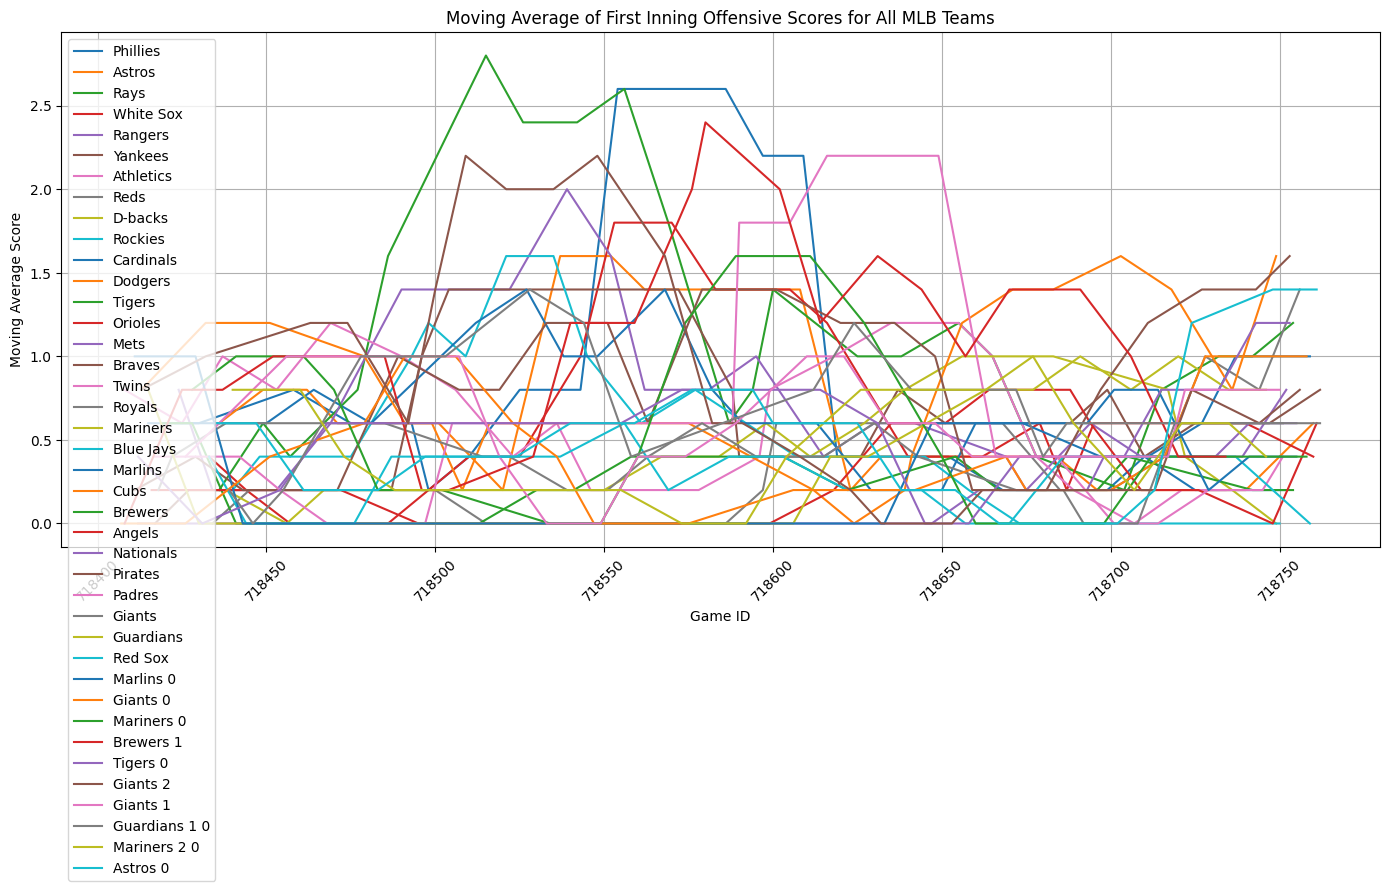

In [5]:
import statsapi
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt

def parse_box_score(box_score):
    """Parse traditional box score string into structured data, ensuring team names are correctly extracted."""
    lines = box_score.strip().split('\n')
    headers = re.findall(r'\d+', lines[0])  # Extract inning numbers from the header
    team_scores = {}

    for line in lines[1:]:  # Skip the header line
        print("Original Line:", line)  # Debug: print the line being processed
        parts = line.split()
        print("Parts:", parts)  # Debug: print the parts split from the line
        team_name_parts = parts[:-len(headers)-3]
        team_name = ' '.join(team_name_parts)
        print("Team Name:", team_name)  # Debug: print the extracted team name
        scores = parts[-len(headers)-3:-3]
        runs, hits, errors = parts[-3], parts[-2], parts[-1]
        team_scores[team_name] = {
            'Inning Scores': scores,
            'Runs': runs,
            'Hits': hits,
            'Errors': errors
        }

    return team_scores

# Define the period for analysis
start_date = '2023-04-01'
end_date = '2023-04-30'

# Fetch schedule for all games played between start_date and end_date
sched = statsapi.schedule(start_date=start_date, end_date=end_date)

# Prepare data for DataFrame
data = []

# Process each game in the schedule
for game in sched:
    game_id = game['game_id']
    print(f"Fetching linescore for game ID {game_id}")
    
    try:
        linescore = statsapi.linescore(game_id)
        if isinstance(linescore, str):  # Assuming linescore returns a string format
            parsed_data = parse_box_score(linescore)
            # Append data for each team
            for team, stats in parsed_data.items():
                for inning, score in enumerate(stats['Inning Scores'], start=1):
                    data.append((team, game_id, 'Offensive', inning, int(score)))
                # Derive defensive data (scores of the opponent)
                for opponent_team, opponent_stats in parsed_data.items():
                    if team != opponent_team:
                        for inning, score in enumerate(opponent_stats['Inning Scores'], start=1):
                            data.append((team, game_id, 'Defensive', inning, int(score)))
        else:
            print("Invalid format or missing innings data")
    except Exception as e:
        print(f"Error fetching linescore for game ID {game_id}: {e}")

# Creating the DataFrame
columns = ['Team', 'Game ID', 'Type', 'Inning', 'Score']
df = pd.DataFrame(data, columns=columns)

# Filter for offensive scores in the first inning
first_inning_df = df[(df['Type'] == 'Offensive') & (df['Inning'] == 1)]

# Group by team and game, and calculate average first inning score
avg_first_inning_scores = first_inning_df.groupby(['Team', 'Game ID']).agg({'Score': 'mean'}).reset_index()

# Sort by game ID for plotting
avg_first_inning_scores.sort_values(by='Game ID', inplace=True)

# Plotting
plt.figure(figsize=(14, 8))
teams = avg_first_inning_scores['Team'].unique()
for team in teams:
    team_data = avg_first_inning_scores[avg_first_inning_scores['Team'] == team]
    team_data['MA Score'] = team_data['Score'].rolling(window=5).mean()  # Calculate moving average
    plt.plot(team_data['Game ID'], team_data['MA Score'], marker='', linestyle='-', label=f'{team}')

plt.title('Moving Average of First Inning Offensive Scores for All MLB Teams')
plt.xlabel('Game ID')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import statsapi
import pandas as pd
import numpy as np
import re

def parse_box_score(box_score):
    """Parse traditional box score string into structured data, ensuring correct extraction of team names."""
    lines = box_score.strip().split('\n')
    team_scores = {}
    
    print("Header:", lines[0])  # Debug: Print the header line
    for line in lines[1:]:
        print("Original Line:", line)  # Debug: print the line being processed
        parts = line.split()
        scores_end_index = -3  # Runs, hits, and errors are the last three elements
        team_name = ' '.join(parts[:-len(parts[-10:-3])-3])  # Assuming fixed position for R, H, E values
        scores = parts[-10:-3]  # Only the inning scores, avoiding R, H, E columns
        runs, hits, errors = parts[-3], parts[-2], parts[-1]
        team_scores[team_name] = {
            'Inning Scores': scores,
            'Runs': runs,
            'Hits': hits,
            'Errors': errors
        }
        print("Parsed Team Name:", team_name)  # Debug: Check extracted team name
        print("Scores:", scores)  # Debug: Print inning scores

    return team_scores

# Fetch a single game box score for testing
game_id = 718760  # Substitute with an actual game ID for testing
box_score = statsapi.boxscore_data(game_id)
box_score_str = box_score['boxscore']  # Assuming 'boxscore_data' provides a string formatted box score

# Parse the box score for the single game
parsed_data = parse_box_score(box_score_str)
print("Parsed Data:", parsed_data)


KeyError: 'boxscore'

In [8]:
import statsapi

# Fetch a single game box score for testing
game_id = 718760  # Substitute with an actual game ID for testing
box_score = statsapi.boxscore_data(game_id)

# Print the keys and structure of the returned data to understand how to access the box score
print("Keys in returned box_score data:", box_score.keys())
print("Full box_score data structure:", box_score)


Keys in returned box_score data: dict_keys(['gameId', 'teamInfo', 'playerInfo', 'away', 'home', 'awayBatters', 'homeBatters', 'awayBattingTotals', 'homeBattingTotals', 'awayBattingNotes', 'homeBattingNotes', 'awayPitchers', 'homePitchers', 'awayPitchingTotals', 'homePitchingTotals', 'gameBoxInfo'])
Full box_score data structure: {'gameId': '2023/04/01/chamlb-houmlb-1', 'teamInfo': {'away': {'id': 145, 'abbreviation': 'CWS', 'teamName': 'White Sox', 'shortName': 'Chi White Sox'}, 'home': {'id': 117, 'abbreviation': 'HOU', 'teamName': 'Astros', 'shortName': 'Houston'}}, 'playerInfo': {'ID518617': {'id': 518617, 'fullName': 'Jake Diekman', 'boxscoreName': 'Diekman'}, 'ID518735': {'id': 518735, 'fullName': 'Yasmani Grandal', 'boxscoreName': 'Grandal'}, 'ID455117': {'id': 455117, 'fullName': 'Martín Maldonado', 'boxscoreName': 'Maldonado, M'}, 'ID650556': {'id': 650556, 'fullName': 'Bryan Abreu', 'boxscoreName': 'Abreu, B'}, 'ID660162': {'id': 660162, 'fullName': 'Yoán Moncada', 'boxscoreNa

In [9]:
import statsapi

# Fetch a single game box score for testing
game_id = 718760  # Substitute with an actual game ID for testing
box_score = statsapi.boxscore_data(game_id)

# Accessing specific team data
away_team_stats = box_score['away']['teamStats']['batting']  # Example for batting stats of the away team
home_team_stats = box_score['home']['teamStats']['batting']  # Example for batting stats of the home team

print("Away Team Batting Stats:", away_team_stats)
print("Home Team Batting Stats:", home_team_stats)

# If you need to parse more specific details like player stats
away_players = box_score['away']['players']
home_players = box_score['home']['players']

# Example: print details for each player on the away team
for player_id, player_info in away_players.items():
    print("Player ID:", player_id)
    print("Full Name:", player_info['person']['fullName'])
    print("Batting Stats:", player_info.get('stats', {}).get('batting', {}))
    print("Pitching Stats:", player_info.get('stats', {}).get('pitching', {}))
    print("\n")


Away Team Batting Stats: {'runs': 4, 'doubles': 0, 'triples': 0, 'homeRuns': 2, 'strikeOuts': 12, 'baseOnBalls': 4, 'hits': 10, 'avg': '.286', 'atBats': 37, 'obp': '.333', 'slg': '.420', 'ops': '.753', 'stolenBases': 2, 'rbi': 4, 'leftOnBase': 21}
Home Team Batting Stats: {'runs': 6, 'doubles': 1, 'triples': 0, 'homeRuns': 0, 'strikeOuts': 8, 'baseOnBalls': 3, 'hits': 11, 'avg': '.234', 'atBats': 36, 'obp': '.345', 'slg': '.319', 'ops': '.664', 'stolenBases': 1, 'rbi': 6, 'leftOnBase': 25}
Player ID: ID518617
Full Name: Jake Diekman
Batting Stats: {}
Pitching Stats: {}


Player ID: ID518735
Full Name: Yasmani Grandal
Batting Stats: {'note': 'a-', 'runs': 0, 'doubles': 0, 'triples': 0, 'homeRuns': 0, 'strikeOuts': 0, 'baseOnBalls': 1, 'hits': 0, 'atBats': 0, 'stolenBases': 0, 'rbi': 0, 'leftOnBase': 0}
Pitching Stats: {}


Player ID: ID663853
Full Name: Romy Gonzalez
Batting Stats: {'note': '1-', 'runs': 0, 'doubles': 0, 'triples': 0, 'homeRuns': 0, 'strikeOuts': 0, 'baseOnBalls': 0, 'h